In [1]:
cd /deac/phy/salsburyGrp/wud18/md/TM_mutant/pca/

/deac/phy/salsburyGrp/wud18/md/TM_mutant/pca


In [2]:
import pyemma.coordinates as coor
import mdtraj as md
import os
%pylab inline
matplotlib.rcParams.update({'font.size': 18})
pylab.rcParams['figure.figsize'] = (14, 11)
cwd = os.getcwd()

Populating the interactive namespace from numpy and matplotlib


In [3]:
def local_min(data,max0=6):
    lmin=[]
    for i in range(48):
        for j in range(48):
            if data[i+1][j] >= data[i][j] and\
               data[i-1][j] >= data[i][j] and\
               data[i][j+1] >= data[i][j] and\
               data[i][j-1] >= data[i][j] and\
               data[i+1][j+1] >= data[i][j] and\
               data[i+1][j-1] >= data[i][j] and\
               data[i-1][j+1] >= data[i][j] and\
               data[i-1][j-1] >= data[i][j] and\
               data[i+2][j] >= data[i][j] and\
               data[i-2][j] >= data[i][j] and\
               data[i][j+2] >= data[i][j] and\
               data[i][j-2] >= data[i][j] and\
               data[i+2][j+1] >= data[i][j] and\
               data[i+2][j-1] >= data[i][j] and\
               data[i-2][j+1] >= data[i][j] and\
               data[i-2][j-1] >= data[i][j] and\
               data[i+1][j+2] >= data[i][j] and\
               data[i+1][j-2] >= data[i][j] and\
               data[i-1][j+2] >= data[i][j] and\
               data[i-1][j-2] >= data[i][j] and\
               data[i+2][j+2] >= data[i][j] and\
               data[i+2][j-2] >= data[i][j] and\
               data[i-2][j+2] >= data[i][j] and\
               data[i-2][j-2] >= data[i][j] and\
               data[i][j] < max0:
                lmin.append([i,j])
    return lmin

In [4]:
def find_sub_min(brr, n):
    arr = brr.copy()
    if n==1:
        arr_ = arr
    else:
        for i in range(n-1):
            arr_ = arr
            arr_[np.argmin(arr_)] = np.max(arr)+0.000000000000001
            arr = arr_
    return np.argmin(arr_)

In [5]:
def examine_well(X,variance,comp1,comp2,type1,vmin,vmax,Title,outname,outputDir,num_of_rep):
    cmap = plt.cm.get_cmap("nipy_spectral")    
    cmap.set_bad('white',1.)
    figure(figsize = (6,4.5))
    nbins=50
    z,x,y = np.histogram2d(X[:,comp1],X[:,comp2], bins=nbins)
    x = 0.5*(x[:-1] + x[1:])
    y = 0.5*(y[:-1] + y[1:])
    overal_bound = [x[0], x[-1], y[0], y[-1]]
    xLabelName='PC{0} ({1:.2f}%)'.format(comp1+1, variance[comp1] * 100)
    yLabelName='PC{0} ({1:.2f}%)'.format(comp2+1, variance[comp2] * 100)
    
    # Histogram frames
    z,x,y = np.histogram2d(X[type1,comp1],X[type1,comp2], bins=nbins)
    x1 = 0.5*(x[:-1] + x[1:])
    y1 = 0.5*(y[:-1] + y[1:])
    extent=[x1[0], x1[-1], y1[0], y1[-1]]
    F1 = -np.log(z)
    F1-=np.min(F1)
    F1[np.where(F1==inf)]=nan
    
    # Positions and values of local minimum point
    lmin=local_min(F1,6)
    print('Local minimum points: ', lmin)
    Fv=[]
    for i in range(len(lmin)):
        Fv.append(F1[lmin[i][0],lmin[i][1]])

    # Plot heat map
    CS1 = contourf(F1.T, 100, cmap=cmap, extent=extent)
    cbar = colorbar(CS1)
    font = {
        #'family' : 'serif',
        #'color'  : 'darkred',
        #'weight' : 'normal',
        'size'   : 14}
    cbar.set_label('Free energy (kT)', fontdict=font)
    xlabel(xLabelName, fontsize=14)
    ylabel(yLabelName, fontsize=14)
    title(Title, fontsize=14)
    xlim(overal_bound[0],overal_bound[1])
    ylim(overal_bound[2],overal_bound[3])
    clim(vmin,vmax)
    
    for i in range(num_of_rep):
        # Find the most populated bin within the selected window
        bin_x,bin_y=lmin[find_sub_min(Fv,i+1)]
        boolean_in_X = np.logical_and(X[type1,comp1]<x[bin_x+1],X[type1,comp1]>x[bin_x])
        boolean_in_Y = np.logical_and(X[type1,comp2]<y[bin_y+1],X[type1,comp2]>y[bin_y])
        boolean_in_XY = np.logical_and(boolean_in_X, boolean_in_Y)
        print('# of frames within the most populated bin',boolean_in_XY.sum())
    
        # Find the representative frame
        binAverage_x = X[type1,comp1][boolean_in_XY].mean()
        binAverage_y = X[type1,comp2][boolean_in_XY].mean()
        distance2ToBinCenter = (X[type1,comp1][boolean_in_XY]-binAverage_x)**2 + \
        (X[type1,comp2][boolean_in_XY]-binAverage_y)**2
        representativeFrame = (type1[boolean_in_XY])[np.argmin(distance2ToBinCenter)]
        print("representativeFrame",representativeFrame)
    
        # Check the location of the representative frame
        text(X[type1,comp1][representativeFrame], X[type1,comp2][representativeFrame], i, fontsize=15, color='white', horizontalalignment='center', verticalalignment='center')
    
        # Write output files
        if not os.path.exists(os.path.join('visualization', outname, outputDir+str(i))):
            os.makedirs(os.path.join('visualization', outname, outputDir+str(i)))
    
        representative_frame = md.load_frame(trajfile,representativeFrame,top = topfile)
        representative_frame.save_pdb(os.path.join('visualization', outname, outputDir+str(i), 'rep.pdb'))
        pca_well_sample = np.column_stack((np.zeros(type1[boolean_in_XY].size),type1[boolean_in_XY]))
        pca_well_sample=pca_well_sample.astype(int)
        coor.save_traj(inp, pca_well_sample, os.path.join('visualization', outname, outputDir+str(i), 'all.dcd'))
    
    # Saving figures
    comp1=str(comp1+1)
    comp2=str(comp2+1)
    outname2=outname+'_PC_'+comp1+'_'+comp2
    
    fig_dir = os.path.join('./figs_togather_wells/',outname)
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    plt.savefig(os.path.join(fig_dir,outname2+'.png'), pad_inches=0.03, bbox_inches='tight', dpi=200)
    plt.savefig(os.path.join(fig_dir,outname2+'.tiff'), pad_inches=0.03, bbox_inches='tight', dpi=600)
    plt.savefig(os.path.join(fig_dir,outname2+'.pdf'), bbox_inches='tight')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/pyemma/__init__.py:92: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.7, you have 2.5.6.
  .format(latest=latest, current=current), category=UserWarning)


In [6]:
path = '/deac/phy/salsburyGrp/wud18/md/TM_mutant/'

In [7]:
# Loading trajectory
stride=1
topfile = path + 'protein_common_atom.pdb'
topology = md.load(topfile).topology
trajfile = path + 'thrombin_TM456_WE_TM456_stride' + str(stride) + '_aligned.dcd'
feat = coor.featurizer(topfile)
inp = coor.source(trajfile, feat)
print('trajectory length = ',inp.trajectory_length(0))
print('number of dimension = ',inp.dimension())
all=np.arange(inp.trajectory_length(0))

trajectory length =  3200000
number of dimension =  14058


In [8]:
# Catalytic Pocket
catalyticPocket_pca=np.load(path+'pca/PcaBasisFromAll/catalyticPockets/projection.npy')
catalyticPocket_variance=np.load(path+'pca/PcaBasisFromAll/catalyticPockets/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


Local minimum points:  [[8, 24], [8, 35], [20, 22], [21, 32], [24, 20], [36, 28], [41, 15], [41, 26], [42, 35]]
# of frames within the most populated bin 27831
representativeFrame 5660


/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1858: RuntimeWarning: invalid value encountered in less
  if self.unitcell_lengths is not None and np.any(self.unitcell_lengths < 0):
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1861: RuntimeWarning: invalid value encountered in less
  if self.unitcell_angles is not None and np.any(self.unitcell_angles < 0):


16-07-23 15:33:47 pyemma.coordinates.api INFO     Created file visualization/catalyticPocket/cluster0/all.dcd
# of frames within the most populated bin 15125
representativeFrame 2244852
16-07-23 15:33:58 pyemma.coordinates.api INFO     Created file visualization/catalyticPocket/cluster1/all.dcd
# of frames within the most populated bin 5778
representativeFrame 418117
16-07-23 15:34:01 pyemma.coordinates.api INFO     Created file visualization/catalyticPocket/cluster2/all.dcd
# of frames within the most populated bin 5402
representativeFrame 2957289
16-07-23 15:34:04 pyemma.coordinates.api INFO     Created file visualization/catalyticPocket/cluster3/all.dcd
# of frames within the most populated bin 1872
representativeFrame 1483206
16-07-23 15:34:06 pyemma.coordinates.api INFO     Created file visualization/catalyticPocket/cluster4/all.dcd
# of frames within the most populated bin 1705
representativeFrame 1966589
16-07-23 15:34:07 pyemma.coordinates.api INFO     Created file visualizatio

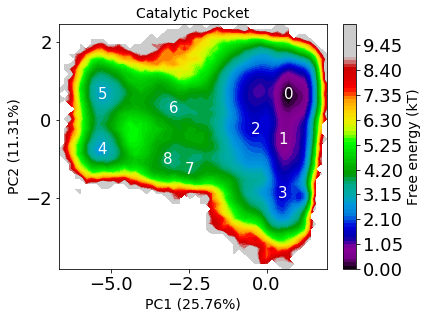

In [38]:
examine_well(catalyticPocket_pca,catalyticPocket_variance,0,1,all,0,9,'Catalytic Pocket','catalyticPocket','cluster',9)

In [10]:
# Regulatory Loops
regulatoryLoops_pca=np.load(path+'pca/PcaBasisFromAll/regulatoryLoops/projection.npy')
regulatoryLoops_variance=np.load(path+'pca/PcaBasisFromAll/regulatoryLoops/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


Local minimum points:  [[8, 20], [14, 18], [14, 30], [19, 5], [23, 15], [26, 24], [32, 33], [36, 26], [37, 18]]
# of frames within the most populated bin 15712
representativeFrame 2721561


/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1858: RuntimeWarning: invalid value encountered in less
  if self.unitcell_lengths is not None and np.any(self.unitcell_lengths < 0):
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1861: RuntimeWarning: invalid value encountered in less
  if self.unitcell_angles is not None and np.any(self.unitcell_angles < 0):


16-07-23 00:20:25 pyemma.coordinates.api INFO     Created file visualization/regulatoryLoops/cluster0/all.dcd
# of frames within the most populated bin 11090
representativeFrame 2277630
16-07-23 00:21:07 pyemma.coordinates.api INFO     Created file visualization/regulatoryLoops/cluster1/all.dcd
# of frames within the most populated bin 10854
representativeFrame 551822
16-07-23 00:21:48 pyemma.coordinates.api INFO     Created file visualization/regulatoryLoops/cluster2/all.dcd
# of frames within the most populated bin 6095
representativeFrame 3192127
16-07-23 00:22:05 pyemma.coordinates.api INFO     Created file visualization/regulatoryLoops/cluster3/all.dcd
# of frames within the most populated bin 4833
representativeFrame 2361401
16-07-23 00:22:26 pyemma.coordinates.api INFO     Created file visualization/regulatoryLoops/cluster4/all.dcd
# of frames within the most populated bin 2001
representativeFrame 1915273
16-07-23 00:22:34 pyemma.coordinates.api INFO     Created file visualizati

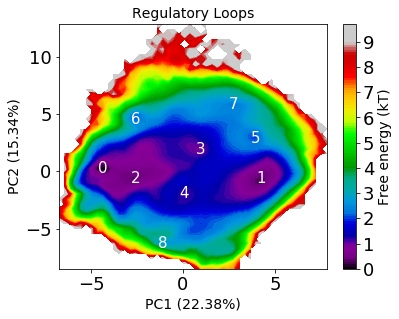

In [11]:
examine_well(regulatoryLoops_pca,regulatoryLoops_variance,0,1,all,0,9,'Regulatory Loops','regulatoryLoops','cluster',9)

In [12]:
# 60s Loop
sixtysLoop_pca=np.load(path+'pca/PcaBasisFromAll/60sLoop/projection.npy')
sixtysLoop_variance=np.load(path+'pca/PcaBasisFromAll/60sLoop/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


Local minimum points:  [[9, 16], [29, 37], [41, 8]]
# of frames within the most populated bin 64217
representativeFrame 1044642


/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1858: RuntimeWarning: invalid value encountered in less
  if self.unitcell_lengths is not None and np.any(self.unitcell_lengths < 0):
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1861: RuntimeWarning: invalid value encountered in less
  if self.unitcell_angles is not None and np.any(self.unitcell_angles < 0):


16-07-23 00:24:37 pyemma.coordinates.api INFO     Created file visualization/60sLoop/cluster0/all.dcd
# of frames within the most populated bin 2683
representativeFrame 1976105
16-07-23 00:25:06 pyemma.coordinates.api INFO     Created file visualization/60sLoop/cluster1/all.dcd
# of frames within the most populated bin 1127
representativeFrame 1379581
16-07-23 00:25:11 pyemma.coordinates.api INFO     Created file visualization/60sLoop/cluster2/all.dcd


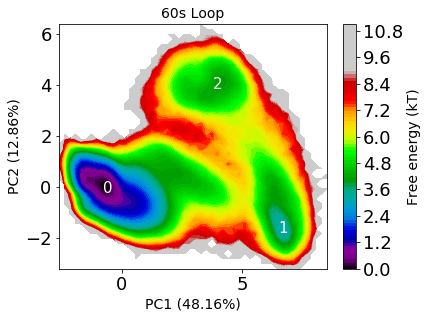

In [13]:
examine_well(sixtysLoop_pca,sixtysLoop_variance,0,1,all,0,9,'60s Loop','60sLoop','cluster',3)

In [14]:
# Helix1 (residue 158 to 166)
helix1_pca=np.load(path+'pca/PcaBasisFromAll/helix1/projection.npy')
helix1_variance=np.load(path+'pca/PcaBasisFromAll/helix1/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


Local minimum points:  [[18, 33], [25, 12], [27, 34], [34, 7], [37, 24]]
# of frames within the most populated bin 20446
representativeFrame 1916130


/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1858: RuntimeWarning: invalid value encountered in less
  if self.unitcell_lengths is not None and np.any(self.unitcell_lengths < 0):
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1861: RuntimeWarning: invalid value encountered in less
  if self.unitcell_angles is not None and np.any(self.unitcell_angles < 0):


16-07-23 15:23:03 pyemma.coordinates.api INFO     Created file visualization/helix1/cluster0/all.dcd
# of frames within the most populated bin 7441
representativeFrame 338063
16-07-23 15:23:42 pyemma.coordinates.api INFO     Created file visualization/helix1/cluster1/all.dcd
# of frames within the most populated bin 2347
representativeFrame 694013
16-07-23 15:23:54 pyemma.coordinates.api INFO     Created file visualization/helix1/cluster2/all.dcd
# of frames within the most populated bin 845
representativeFrame 3083671
16-07-23 15:23:58 pyemma.coordinates.api INFO     Created file visualization/helix1/cluster3/all.dcd
# of frames within the most populated bin 829
representativeFrame 399539
16-07-23 15:24:03 pyemma.coordinates.api INFO     Created file visualization/helix1/cluster4/all.dcd


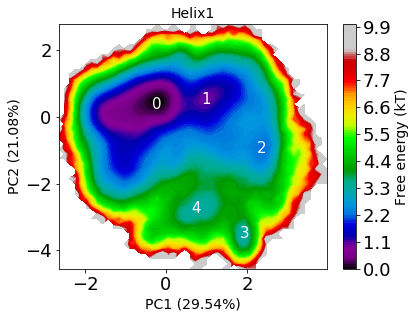

In [35]:
examine_well(helix1_pca,helix1_variance,0,1,all,0,9,'Helix1','helix1','cluster',5)

In [16]:
# Gamma Loop
gammaLoop_pca=np.load(path+'pca/PcaBasisFromAll/gammaLoop/projection.npy')
gammaLoop_variance=np.load(path+'pca/PcaBasisFromAll/gammaLoop/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


Local minimum points:  [[12, 17], [13, 27], [18, 34], [23, 24], [25, 15], [26, 12], [36, 18], [41, 20]]
# of frames within the most populated bin 16078
representativeFrame 2688053


/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1858: RuntimeWarning: invalid value encountered in less
  if self.unitcell_lengths is not None and np.any(self.unitcell_lengths < 0):
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1861: RuntimeWarning: invalid value encountered in less
  if self.unitcell_angles is not None and np.any(self.unitcell_angles < 0):


16-07-23 00:27:49 pyemma.coordinates.api INFO     Created file visualization/gammaLoop/cluster0/all.dcd
# of frames within the most populated bin 11505
representativeFrame 50106
16-07-23 00:28:06 pyemma.coordinates.api INFO     Created file visualization/gammaLoop/cluster1/all.dcd
# of frames within the most populated bin 9932
representativeFrame 3026745
16-07-23 00:28:20 pyemma.coordinates.api INFO     Created file visualization/gammaLoop/cluster2/all.dcd
# of frames within the most populated bin 6050
representativeFrame 1504944
16-07-23 00:28:30 pyemma.coordinates.api INFO     Created file visualization/gammaLoop/cluster3/all.dcd
# of frames within the most populated bin 4479
representativeFrame 889367
16-07-23 00:28:37 pyemma.coordinates.api INFO     Created file visualization/gammaLoop/cluster4/all.dcd
# of frames within the most populated bin 4445
representativeFrame 2385386
16-07-23 00:28:46 pyemma.coordinates.api INFO     Created file visualization/gammaLoop/cluster5/all.dcd
# o

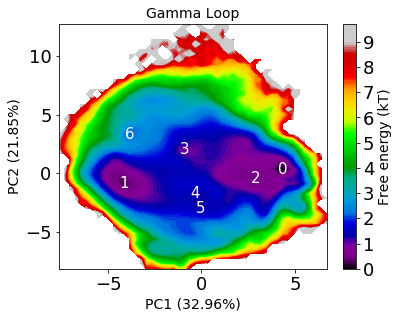

In [17]:
examine_well(gammaLoop_pca,gammaLoop_variance,0,1,all,0,9,'Gamma Loop','gammaLoop','cluster',7)

In [18]:
# 170s Loop (residue 205 to 212)
I70sLoop_pca=np.load(path+'pca/PcaBasisFromAll/170sLoop/projection.npy')
I70sLoop_variance=np.load(path+'pca/PcaBasisFromAll/170sLoop/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


Local minimum points:  [[18, 27], [24, 12], [25, 39], [37, 25]]
# of frames within the most populated bin 22778
representativeFrame 3074669


/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1858: RuntimeWarning: invalid value encountered in less
  if self.unitcell_lengths is not None and np.any(self.unitcell_lengths < 0):
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1861: RuntimeWarning: invalid value encountered in less
  if self.unitcell_angles is not None and np.any(self.unitcell_angles < 0):


16-07-23 00:30:34 pyemma.coordinates.api INFO     Created file visualization/170sLoop/cluster0/all.dcd
# of frames within the most populated bin 3235
representativeFrame 290994
16-07-23 00:30:53 pyemma.coordinates.api INFO     Created file visualization/170sLoop/cluster1/all.dcd
# of frames within the most populated bin 1927
representativeFrame 2454769
16-07-23 00:31:01 pyemma.coordinates.api INFO     Created file visualization/170sLoop/cluster2/all.dcd
# of frames within the most populated bin 1146
representativeFrame 2529432
16-07-23 00:31:07 pyemma.coordinates.api INFO     Created file visualization/170sLoop/cluster3/all.dcd


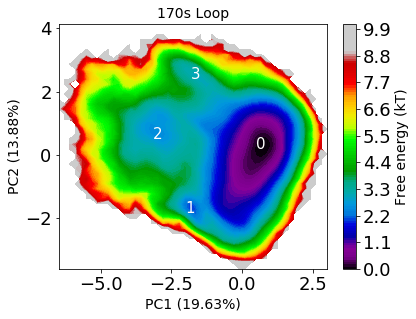

In [19]:
examine_well(I70sLoop_pca,I70sLoop_variance,0,1,all,0,9,'170s Loop','170sLoop','cluster',4)

In [20]:
# 180s Loop (residue 205 to 212)
I80sLoop_pca=np.load(path+'pca/PcaBasisFromAll/180sLoop/projection.npy')
I80sLoop_variance=np.load(path+'pca/PcaBasisFromAll/180sLoop/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


Local minimum points:  [[13, 23], [25, 21], [33, 19]]
# of frames within the most populated bin 36334
representativeFrame 2710626


/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1858: RuntimeWarning: invalid value encountered in less
  if self.unitcell_lengths is not None and np.any(self.unitcell_lengths < 0):
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1861: RuntimeWarning: invalid value encountered in less
  if self.unitcell_angles is not None and np.any(self.unitcell_angles < 0):


16-07-23 00:31:51 pyemma.coordinates.api INFO     Created file visualization/180sLoop/cluster0/all.dcd
# of frames within the most populated bin 5798
representativeFrame 2731275
16-07-23 00:32:16 pyemma.coordinates.api INFO     Created file visualization/180sLoop/cluster1/all.dcd
# of frames within the most populated bin 5345
representativeFrame 481021
16-07-23 00:32:51 pyemma.coordinates.api INFO     Created file visualization/180sLoop/cluster2/all.dcd


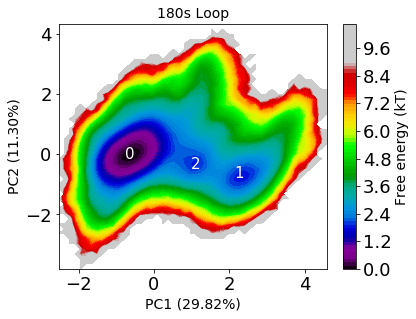

In [21]:
examine_well(I80sLoop_pca,I80sLoop_variance,0,1,all,0,9,'180s Loop','180sLoop','cluster',3)

In [22]:
# Sodium Loop
sodiumLoop_pca=np.load(path+'pca/PcaBasisFromAll/sodiumLoop/projection.npy')
sodiumLoop_variance=np.load(path+'pca/PcaBasisFromAll/sodiumLoop/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


Local minimum points:  [[7, 32], [13, 34], [28, 16], [34, 29]]
# of frames within the most populated bin 40484
representativeFrame 1017377


/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1858: RuntimeWarning: invalid value encountered in less
  if self.unitcell_lengths is not None and np.any(self.unitcell_lengths < 0):
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1861: RuntimeWarning: invalid value encountered in less
  if self.unitcell_angles is not None and np.any(self.unitcell_angles < 0):


16-07-23 00:35:35 pyemma.coordinates.api INFO     Created file visualization/220sLoop/cluster0/all.dcd
# of frames within the most populated bin 3977
representativeFrame 2614877
16-07-23 00:36:04 pyemma.coordinates.api INFO     Created file visualization/220sLoop/cluster1/all.dcd
# of frames within the most populated bin 1518
representativeFrame 895594
16-07-23 00:36:10 pyemma.coordinates.api INFO     Created file visualization/220sLoop/cluster2/all.dcd


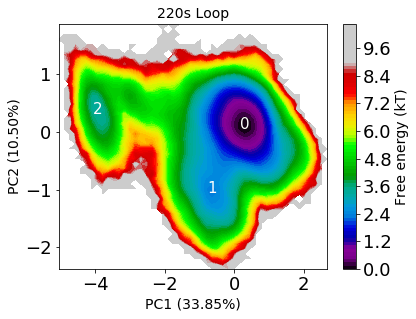

In [23]:
examine_well(sodiumLoop_pca,sodiumLoop_variance,0,1,all,0,9,'220s Loop','220sLoop','cluster',3)

In [24]:
# Catalytic Triad
catalyticTriad_pca=np.load(path+'pca/PcaBasisFromAll/catalyticTriad/projection.npy')
catalyticTriad_variance=np.load(path+'pca/PcaBasisFromAll/catalyticTriad/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


Local minimum points:  [[32, 21]]
# of frames within the most populated bin 27517
representativeFrame 240512


/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1858: RuntimeWarning: invalid value encountered in less
  if self.unitcell_lengths is not None and np.any(self.unitcell_lengths < 0):
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1861: RuntimeWarning: invalid value encountered in less
  if self.unitcell_angles is not None and np.any(self.unitcell_angles < 0):


16-07-23 00:38:28 pyemma.coordinates.api INFO     Created file visualization/catalyticTriad/cluster0/all.dcd


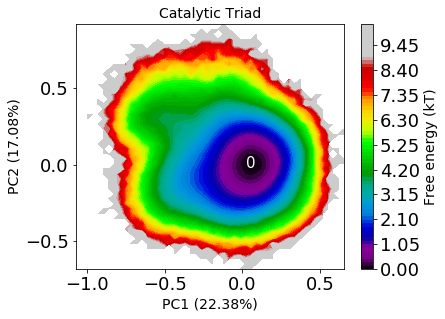

In [25]:
examine_well(catalyticTriad_pca,catalyticTriad_variance,0,1,all,0,9,'Catalytic Triad','catalyticTriad','cluster',1)

In [26]:
# Exosite I
exositeI_pca=np.load(path+'pca/PcaBasisFromAll/exositeI/projection.npy')
exositeI_variance=np.load(path+'pca/PcaBasisFromAll/exositeI/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


Local minimum points:  [[9, 27], [34, 39], [36, 35], [38, 18]]
# of frames within the most populated bin 23770
representativeFrame 1361302


/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1858: RuntimeWarning: invalid value encountered in less
  if self.unitcell_lengths is not None and np.any(self.unitcell_lengths < 0):
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1861: RuntimeWarning: invalid value encountered in less
  if self.unitcell_angles is not None and np.any(self.unitcell_angles < 0):


16-07-23 00:40:04 pyemma.coordinates.api INFO     Created file visualization/exositeI/cluster0/all.dcd
# of frames within the most populated bin 426
representativeFrame 394972
16-07-23 00:40:06 pyemma.coordinates.api INFO     Created file visualization/exositeI/cluster1/all.dcd


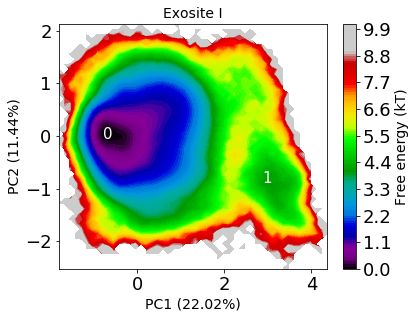

In [27]:
examine_well(exositeI_pca,exositeI_variance,0,1,all,0,9,'Exosite I','exositeI','cluster',2)

In [28]:
# Exosite II
exositeII_pca=np.load(path+'pca/PcaBasisFromAll/exositeII/projection.npy')
exositeII_variance=np.load(path+'pca/PcaBasisFromAll/exositeII/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


Local minimum points:  [[17, 24], [32, 15], [38, 25]]
# of frames within the most populated bin 20724
representativeFrame 1156386


/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1858: RuntimeWarning: invalid value encountered in less
  if self.unitcell_lengths is not None and np.any(self.unitcell_lengths < 0):
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1861: RuntimeWarning: invalid value encountered in less
  if self.unitcell_angles is not None and np.any(self.unitcell_angles < 0):


16-07-23 00:41:50 pyemma.coordinates.api INFO     Created file visualization/exositeII/cluster0/all.dcd
# of frames within the most populated bin 10394
representativeFrame 600794
16-07-23 00:42:41 pyemma.coordinates.api INFO     Created file visualization/exositeII/cluster1/all.dcd
# of frames within the most populated bin 2613
representativeFrame 2070675
16-07-23 00:42:55 pyemma.coordinates.api INFO     Created file visualization/exositeII/cluster2/all.dcd


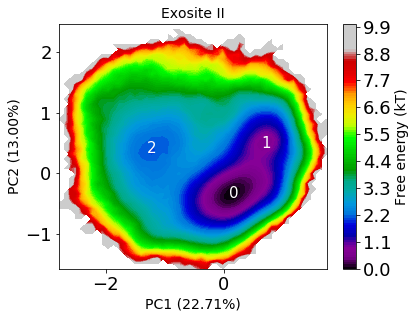

In [29]:
examine_well(exositeII_pca,exositeII_variance,0,1,all,0,9,'Exosite II','exositeII','cluster',3)

In [30]:
# Connection
connection_pca=np.load(path+'pca/PcaBasisFromAll/connection/projection.npy')
connection_variance=np.load(path+'pca/PcaBasisFromAll/connection/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


Local minimum points:  [[13, 34], [17, 16], [27, 40], [36, 28]]
# of frames within the most populated bin 46260
representativeFrame 3096454


/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1858: RuntimeWarning: invalid value encountered in less
  if self.unitcell_lengths is not None and np.any(self.unitcell_lengths < 0):
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1861: RuntimeWarning: invalid value encountered in less
  if self.unitcell_angles is not None and np.any(self.unitcell_angles < 0):


16-07-23 00:46:15 pyemma.coordinates.api INFO     Created file visualization/connection/cluster0/all.dcd
# of frames within the most populated bin 638
representativeFrame 538494
16-07-23 00:46:19 pyemma.coordinates.api INFO     Created file visualization/connection/cluster1/all.dcd
# of frames within the most populated bin 389
representativeFrame 2573387
16-07-23 00:46:21 pyemma.coordinates.api INFO     Created file visualization/connection/cluster2/all.dcd
# of frames within the most populated bin 263
representativeFrame 2596932
16-07-23 00:46:23 pyemma.coordinates.api INFO     Created file visualization/connection/cluster3/all.dcd


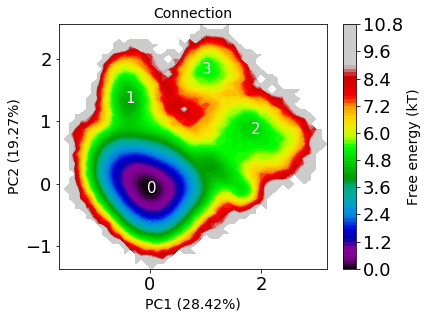

In [31]:
examine_well(connection_pca,connection_variance,0,1,all,0,9,'Connection','connection','cluster',4)

In [32]:
# 30s Loop
thirtysLoop_pca=np.load(path+'pca/PcaBasisFromAll/30sLoop/projection.npy')
thirtysLoop_variance=np.load(path+'pca/PcaBasisFromAll/30sLoop/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


Local minimum points:  [[18, 22]]
# of frames within the most populated bin 30942
representativeFrame 2296544


/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1858: RuntimeWarning: invalid value encountered in less
  if self.unitcell_lengths is not None and np.any(self.unitcell_lengths < 0):
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1861: RuntimeWarning: invalid value encountered in less
  if self.unitcell_angles is not None and np.any(self.unitcell_angles < 0):


16-07-23 00:48:56 pyemma.coordinates.api INFO     Created file visualization/30sLoop/cluster0/all.dcd


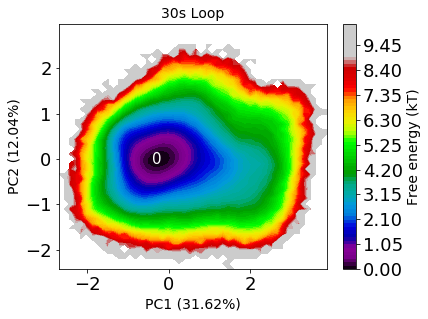

In [33]:
examine_well(thirtysLoop_pca,thirtysLoop_variance,0,1,all,0,9,'30s Loop','30sLoop','cluster',1)

In [34]:
# Helix2 (residue 205 to 212)
helix2_pca=np.load(path+'pca/PcaBasisFromAll/helix2/projection.npy')
helix2_variance=np.load(path+'pca/PcaBasisFromAll/helix2/variance.npy')

FileNotFoundError: [Errno 2] No such file or directory: '/deac/phy/salsburyGrp/wud18/md/TM_mutant/pca/PcaBasisFromAll/helix2/projection.npy'

In [ ]:
examine_well(helix2_pca,helix2_variance,0,1,all,0,9,'Helix2','helix2','cluster',1)

In [ ]:
# Beta Sheet1
betaSheet1_pca=np.load(path+'pca/PcaBasisFromAll/betaSheet1/projection.npy')
betaSheet1_variance=np.load(path+'pca/PcaBasisFromAll/betaSheet1/variance.npy')

In [ ]:
examine_well(betaSheet1_pca,betaSheet1_variance,0,1,all,0,9,'Beta Sheet1','betaSheet1','cluster',2)